## Lesson 2: AWS Data Exchange and STAC

**Objective:** Familiarization with the [AWS Data Exchange](https://aws.amazon.com/marketplace/search/results?trk=8384929b-0eb1-4af3-8996-07aa409646bc&sc_channel=el&FULFILLMENT_OPTION_TYPE=DATA_EXCHANGE&CONTRACT_TYPE=OPEN_DATA_LICENSES&filters=FULFILLMENT_OPTION_TYPE%2CCONTRACT_TYPE). Walkthrough various methods of consuming a dataset from the exchange, via different methods including:
- AWS CLI utility
- SpatioTemporal Asset Catalog (STAC) via [Python](https://pystac-client.readthedocs.io/en/stable/)
- STAC via the [Browser](https://radiantearth.github.io/stac-browser/#/?.language=en)
- STAC via Desktop GIS Software ([QGIS](https://www.lutraconsulting.co.uk/blogs/stac-in-qgis) / [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/create-a-stac-connection.htm))

## AWS Data Exchange

The AWS Data Exchange is a index of third party datasets that can be incorporated into your cloud-based workflow. These datasets encompass a variety of domains beyond environmental science and are a mixture of freely available data under `Open Data Licenses` and those that are subject to a subscription agreement.

The following link constrains the result set only to those with `Open Data Licenses`: https://aws.amazon.com/marketplace/search/results?sc_channel=el&FULFILLMENT_OPTION_TYPE=DATA_EXCHANGE&CONTRACT_TYPE=OPEN_DATA_LICENSES&filters=FULFILLMENT_OPTION_TYPE%2CCONTRACT_TYPE

As mentioned, the breadth of these datasets hosted on the exchange is large. They can include derived data such as this global land use land cover dataset, as well as foundational data such as this collection of [Sentinel-2 Cloud-Optimized GeoTIFFs](https://aws.amazon.com/marketplace/pp/prodview-ykj5gyumkzlme?sr=0-50&ref_=beagle&applicationId=AWSMPContessa#resources)

Each dataset is accompanied by documentation of varying levels of completeness. Sections include:

**Description**

![02_sentinel_description.png](./assets/02_sentinel_description.png)

**Resources**

![02_sentinel_resources.png](./assets/02_sentinel_resources.png)

**Usage Examples**

![02_sentinel_examples.png](./assets/02_sentinel_examples.png)

## Dataset Exploration Sentinel-2 Imagery

Let's take a further look at the Sentinel-2 imagery using some of the links provided in the dataset's landing page: https://aws.amazon.com/marketplace/pp/prodview-ykj5gyumkzlme?sr=0-50&ref_=beagle&applicationId=AWSMPContessa#usage

Firstly, the landing page gives us a snippet to inspect the dataset's S3 bucket directly using the `aws s3` CLI utility.

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

bucket = "e84-earth-search-sentinel-data"

# Anonymous / unsigned client (equivalent to --no-sign-request)
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

resp = s3.list_objects_v2(Bucket=bucket, Delimiter="/")
for obj in resp.get("CommonPrefixes", []):
    print(obj["Prefix"])

sentinel-2-c1-l2a/
sentinel-2-pre-c1-l2a/


We're presented with two additional prefixes, and it's not entirely clear what data are contained in each. Let's try to dig further.

In [2]:
prefix="sentinel-2-c1-l2a/"
sentinel_2_files = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# List the first 20 objects in the `sentinel-2-c1-l2a/` prefix.
for obj in sentinel_2_files.get("Contents",[])[:20]:
    print(f"{obj['Key']} {obj['Size'] / 1024:.2f} KB")

sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/AOT.tif 128.35 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B01.tif 1341.72 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B02.tif 35653.22 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B03.tif 36041.18 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B04.tif 36621.21 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B05.tif 11517.91 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B06.tif 11571.46 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B07.tif 11573.79 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B08.tif 37643.38 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B09.tif 1279.71 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B11.tif 10503.64 KB
sentinel-2-c1-l2a/1/C/CV/2018/10/S2B_T01CCV_20181004T210521_L2A/B12.tif 10495.88

There are clearly a lot of files in this S3 bucket following some type of a standardized naming structure. For us though, there has to be a better way to navigate this complex organization of data. The answer is yes, and it's through the SpatioTemporal Asset Catalog (STAC) service that accompanies this dataset, which is referenced in the dataset's [Resources section](https://aws.amazon.com/marketplace/pp/prodview-ykj5gyumkzlme?sr=0-50&ref_=beagle&applicationId=AWSMPContessa#resources).

## Dataset Exporation via STAC

From https://stacspec.org/
> The STAC specification is a **common language to describe geospatial information,** so it can more easily be worked with, indexed, and discovered.

Whereas above we were exploring the Sentinel-2 S3 bucket manually much as we would a directory of images, we can leverage its accompanying STAC Collection allowing us to search for images based on spatial extent, keywords, or timeframe. 

Because STAC is a standard specification, software has been built around it allowing us to search these data in the browser, programmatically, or through a desktop GIS.

One quick way to interact with a STAC endpoint is to drop it into the STAC Browser web application provided by Radiant Earth: https://radiantearth.github.io/stac-browser/

**Click the following link to open an instance of the STAC Browser prepopulated with a reference to the Sentinel-2 imagery's STAC endpoint: https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a?.language=en**

We can quickly filter down to a single scene, known as an `Item` in STAC terminology, such as this `Item` which was found by searching for imagery within the spatial extent of Madrid: https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a/items/S2A_T30TVK_20251026T110826_L2A?.language=en

![02_STACBrowser_Item.png](./assets/02_STACBrowser_Item.png)

## STAC Exploration via Python

There are a number of python packages that allow us to programmatically explore STAC endpoints as well. One of the most commonly used is the [`pystac-client` package](https://pystac-client.readthedocs.io/en/stable/#).

Lets see how we can use Python to execute a similar search for Sentinel-2 imagery over Madrid.

Firstly, we'll get the list of `collections` that the `catalog` contains.

In [3]:
from pystac_client import Client

## STAC URL Taken from the AWS Data Exchange page, but note we've removed everying after `v1`
## This URL represents the catalog or root.
SENTINEL2_STAC_CATALOG_URL = "https://earth-search.aws.element84.com/v1"
catalog = Client.open(SENTINEL2_STAC_CATALOG_URL)

for collection in catalog.get_collections():
    print(f"Collection ID: {collection.id} | Title: {collection.title}")

Collection ID: sentinel-2-pre-c1-l2a | Title: Sentinel-2 Pre-Collection 1 Level-2A 
Collection ID: cop-dem-glo-30 | Title: Copernicus DEM GLO-30
Collection ID: naip | Title: NAIP: National Agriculture Imagery Program
Collection ID: cop-dem-glo-90 | Title: Copernicus DEM GLO-90
Collection ID: landsat-c2-l2 | Title: Landsat Collection 2 Level-2
Collection ID: sentinel-2-l2a | Title: Sentinel-2 Level-2A
Collection ID: sentinel-2-l1c | Title: Sentinel-2 Level-1C
Collection ID: sentinel-2-c1-l2a | Title: Sentinel-2 Collection 1 Level-2A
Collection ID: sentinel-1-grd | Title: Sentinel-1 Level-1C Ground Range Detected (GRD)


From our STAC Browser screenshots above, we were looking within the `Sentinel-2 Collection 1 Level-2A` collection, which matches to an ID in our list of `sentinel-2-c1-l2a`.

Alternatively, we could have searched directly for the collection by name as seen below. This could be useful if the catalog contains many collections.

In [4]:
collection_name = "Sentinel-2 Collection 1 Level-2A"
results = catalog.collection_search(q=collection_name)
for collection in results.collections():
    print(f"Collection ID: {collection.id} | Title: {collection.title}")

Collection ID: sentinel-2-pre-c1-l2a | Title: Sentinel-2 Pre-Collection 1 Level-2A 
Collection ID: sentinel-2-c1-l2a | Title: Sentinel-2 Collection 1 Level-2A


/home/sagemaker-user/.conda/envs/ocs-intermediate-binder/lib/python3.11/site-packages/pystac_client/collection_search.py:306: UserWarning: Server does not conform to COLLECTION_SEARCH. Filtering will be performed client-side where only bbox, datetime, and q arguments are supported
  warnings.warn(


Now that we know our collection of interest, lets try to find the scene depicted in the STAC Browser screenshot above.

We know the scene ID is `S2A_T30TVK_20251026T110826_L2A`, but we also know the location (Madrid) and the collection date `2025-10-26 11:10:23 UTC`. Let's search based on location and date, and see what scenes are returned.

In [5]:
## Bounding Box Genearated using https://geojson.io/#map=9.52/40.3197/-3.5271
madrid_bbox = {
    "type": "Polygon",
    "coordinates": [
        [
            [-3.815, 40.523],
            [-3.815, 40.290],
            [-3.521, 40.290],
            [-3.521, 40.523],
            [-3.815, 40.523]
        ]
    ]
}

item_search = catalog.search(
    collections="sentinel-2-c1-l2a",
    intersects=madrid_bbox,
    datetime="2025-10-26"
)

items = list(item_search.items())
items

[<Item id=S2A_T30TVK_20251026T110826_L2A>]

We've successfully found the same scene we saw in STAC Browser. By running the cell below, We can browse its metadata here as well. Each entry of the `assets` dictionary represents a work product we can interact with for this scene.

In [6]:
madrid_scene = items[0]
madrid_scene

<Item id=S2A_T30TVK_20251026T110826_L2A>

We can use a library such as `rasterio` to visualize any of the Cloud Optimized GeoTIFF assets in this scene. Below, we visualize the truecolor `preview` asset, which has a smaller file size.

More info can be found on the `rasterio` [docs site](https://rasterio.readthedocs.io/en/stable/topics/plotting.html).

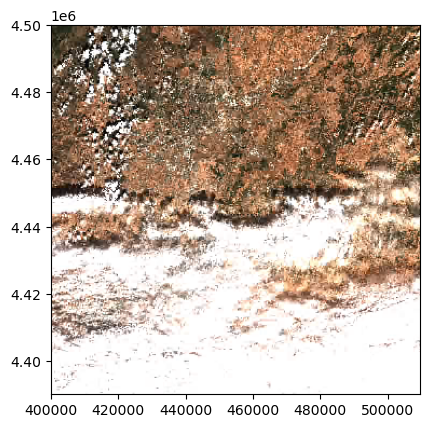

In [7]:
import rasterio
from rasterio.plot import show

with rasterio.open(madrid_scene.assets["preview"].href) as dataset:
    show(dataset)

An alternative to the `rasterio` library for interacting with underlying data retrieved from a STAC endpoint is the `xarray` package. 

`xarray` is designed to easily work with multi-dimensional arrays within python. Building on our example here, `xarray` could be used to analyze one or more bands of Sentinel-2 imagery for spatial extent of Madrid, over the temporal extent of the dataset (2017-Present according to the AWS Data Exchange page.

**NOTE:** To learn more about `xarray` and advanced cloud-based analysis workflows, please consider attending the Advanced workshop module at **Feb 24 from 11am EST to 1pm EST or Feb 25 from 8pm EST to 10pm EST**

## STAC In Desktop GIS

STAC Catalogs can be viewed both in ArcGIS Pro and QGIS Desktop, generally with good results. In practice, I've run into rough edges in both software. I attribute this to the fact that ArcGIS Pro and QGIS both need to support STAC Catalogs that can be either static (a pre-generated set of JSON files) or dynamic (an API is queried to filter the data based on some attribute such as spatial extent or time). Additionally, with regards to QGIS Desktop, it appears that there are a few different plugins available for creating STAC connections, with varying levels of robustness.

In general though, both software appear to do a good job allowing a user to search and display STAC catalogs.

### ArcGIS Pro

STAC Catalogs can viewed by creating a STAC connection. See the [Esri documentation](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/create-a-stac-connection.htm) for more details.

One important note is that when creating a connection in ArcGIS Pro, you need to provide a link to the STAC Catalog (the root-level element), not the STAC Collection (a child of the Catalog).

For our Sentinel-2 imagery from the AWS Data exchange:
- the STAC Catalog URL is: https://earth-search.aws.element84.com/v1
- Whereas the URL listed on the Data Exchange page itself is for a STAC Collection within that Catalog: https://earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a

**Exploring a STAC Catalog**

![02_ArcGISPro_STAC_Explore.png](./assets/02_ArcGISPro_STAC_Explore.png)

**Loading an Image From a Catalog**

![02_ArcGISPro_STAC_Render.png](./assets/02_ArcGISPro_STAC_Render.png)

### QGIS

Creating STAC connections in QGIS for both static and API-based catalogs is entirely possible, but they require different workflows. This blog post from Lutra Consulting provides a clear walkthrough for both, and is recommended reading: https://www.lutraconsulting.co.uk/blogs/stac-in-qgis

The QGIS UI, via the `Data Source Manager` offers a similar interface to search and filter the Sentinel STAC collection, allowing us to quickly find the same scene over Madrid.

**Exploring The STAC Catalog Via QGIS Data Source Manager**

![02_QGIS_STAC_DataSourceManager.png](./assets/02_QGIS_STAC_DataSourceManager.png)

**Adding Image To QGIS Map Project**

![02_QGIS_STAC_Rendered.png](./assets/02_QGIS_STAC_Rendered.png)

## Conclusions

In this lesson we've introduced the [AWS Data Exchange](https://aws.amazon.com/marketplace/search/results?sc_channel=el&FULFILLMENT_OPTION_TYPE=DATA_EXCHANGE&CONTRACT_TYPE=OPEN_DATA_LICENSES&filters=FULFILLMENT_OPTION_TYPE%2CCONTRACT_TYPE), an index of both open and subscription based datasets. Dataset entries will often times have useful usage examples and documentation, although quality may vary.

We saw how to take one of these datasets, containing [Cloud Optimized GeoTIFFs for Sentinel-2 imagery](https://aws.amazon.com/marketplace/pp/prodview-ykj5gyumkzlme#resources) and interact with it in a variety of ways including:

- Accessing the S3 bucket directly via the AWS CLI utility.
- Using a SpatioTemporal Asset Catalog (STAC) endpoint via the STAC Browser
- STAC exploration via the python `pystac-client` library
- STAC exploration via Desktop GIS software.

## Additional Resources

- [AWS Data Exchange: Open Data Licensed Datasets](https://aws.amazon.com/marketplace/search/results?sc_channel=el&FULFILLMENT_OPTION_TYPE=DATA_EXCHANGE&CONTRACT_TYPE=OPEN_DATA_LICENSES&filters=FULFILLMENT_OPTION_TYPE%2CCONTRACT_TYPE)
- USGS Tutorials on Discovering and Downloading Data with STAC via:
  - [Command Line Interface](https://stac.astrogeology.usgs.gov/docs/tutorials/cli/)
  - [Python](https://stac.astrogeology.usgs.gov/docs/tutorials/basicpython/)
- [STAC Index](https://stacindex.org/): A rollup of STAC Catalogs, APIs, Software and Tools.
  - Also see STAC Index's [Learning Resources section](https://stacindex.org/learn) for a list of tutorials and workshops.
- [STAC Browser](https://radiantearth.github.io/stac-browser/#/?.language=en): A web application for interactively searching a STAC endpoint.